In [1]:
'''
    Extracted from PyTorch tutorial for Character Generation with RNN
    Included to generate Nepali Names
    
    Date - 11/20/2018
'''

from __future__ import unicode_literals, print_function, division
from io import open
import glob
import unicodedata
import string

# To include devnagari letters
devnagari = ""
for i in range(2304, 2383):
    devnagari += chr(i)

all_letters = string.ascii_letters + devnagari + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

print(all_letters)
print(n_letters)

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)
print(unicodeToAscii('ओयेश'))


abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZऀँंःऄअआइईउऊऋऌऍऎएऐऑऒओऔकखगघङचछजझञटठडढणतथदधनऩपफबभमयरऱलळऴवशषसहऺऻ़ऽािीुूृॄॅॆेैॉॊोौ्ॎ .,;'-
138
# categories: 19 ['Spanish', 'Korean', 'French', 'Chinese', 'Italian', 'Russian', 'Nepali', 'Arabic', 'Dutch', 'Japanese', 'English', 'Polish', 'Vietnamese', 'German', 'Portuguese', 'Irish', 'Scottish', 'Greek', 'Czech']
ओयश


In [2]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [3]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# Get a random category and random line from that category
def randomName(category='Nepali'):
    line = randomChoice(category_lines[category])
    return category, line

In [4]:
randomName()

('Nepali', 'सबिन')

In [5]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [6]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

# Make category, input, and target tensors from a random category, line pair
def mock_randomTrainingExample():
    category, line = randomName()
    print('Name: ',line)
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [7]:
category_tensor, input_line_tensor, target_line_tensor = mock_randomTrainingExample()
print(target_line_tensor)
print(n_letters)

Name:  अशमा
tensor([106,  98, 114, 137])
138


In [8]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [9]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

rnn = RNN(n_letters, 128, n_letters)

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    loss = 0
    
    rnn.zero_grad()

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    
    if loss == 0:
        print("Input line tensor size = ", input_line_tensor.size(0))
        print("Inside loss = ", loss)
        print(category_tensor)
        
    loss.backward()
   

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

In [10]:
category_tensor, input_line_tensor, target_line_tensor = randomTrainingExample()
output, loss = train(category_tensor, input_line_tensor, target_line_tensor)
print("Category Tensor:", category_tensor.shape)
print("Input shape:",input_line_tensor.shape)
print("Target line tensor:",target_line_tensor.shape)
print("Output shape:",output.shape)
print("Loss:", loss)


Category Tensor: torch.Size([1, 19])
Input shape: torch.Size([2, 1, 138])
Target line tensor: torch.Size([2, 1])
Output shape: torch.Size([1, 138])
Loss: 4.895919322967529


In [11]:
rnn = RNN(n_letters, 100, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters+1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter/n_iters * 100, loss))
        
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 26s (5000 5%) 2.6343
0m 56s (10000 10%) 2.1942
1m 35s (15000 15%) 2.1304
2m 14s (20000 20%) 2.7490
2m 46s (25000 25%) 2.7622
3m 20s (30000 30%) 2.0742
3m 52s (35000 35%) 2.1995
4m 20s (40000 40%) 1.9509
5m 8s (45000 45%) 4.2864
5m 43s (50000 50%) 1.7812
6m 22s (55000 55%) 1.7052
6m 59s (60000 60%) 2.2467
7m 31s (65000 65%) 3.3301
8m 8s (70000 70%) 1.7843
8m 40s (75000 75%) 2.1439
9m 14s (80000 80%) 2.2198
9m 47s (85000 85%) 3.5125
10m 17s (90000 90%) 2.2364
10m 47s (95000 95%) 2.8402
11m 23s (100000 100%) 2.1846


In [453]:
# Save torch model
torch.save(rnn.state_dict(),f='char_rnn_gen.model')

<IPython.core.display.Javascript object>


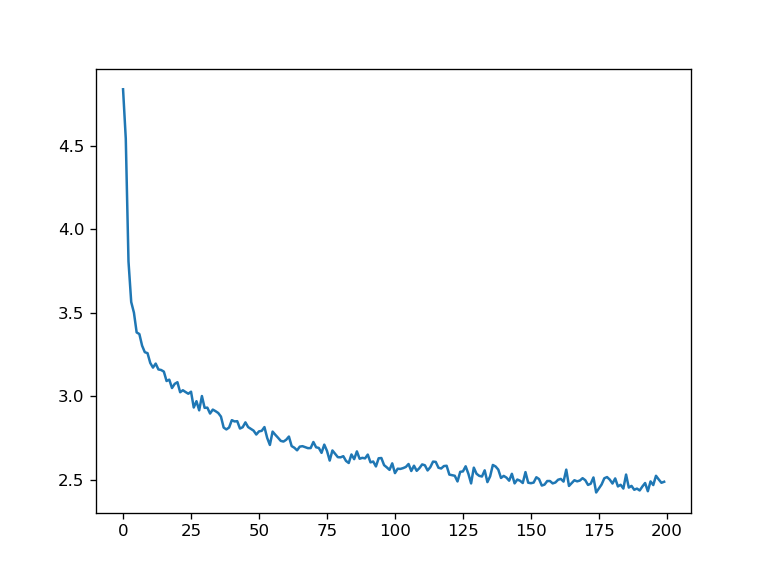

In [454]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [456]:
# Load model
rnn.load_state_dict(torch.load('char_rnn_gen.model'))

In [489]:
from torch.autograd import Variable

max_length = 20

#Sample from a category and  starting letter
def sample(category, start_letter = 'A'):
    category_tensor = Variable(categoryTensor(category))
    input = Variable(inputTensor(start_letter))
    hidden = rnn.initHidden()
    
    output_name = start_letter
    
    for i in range(max_length):
        output, hidden = rnn(category_tensor, input[0], hidden)
        topv, topi = output.data.topk(1)
        topi = topi[0][0]
        if topi == n_letters-1:
            break
        else:
            letter = all_letters[topi]
            output_name += letter
            
        input = Variable(inputTensor(letter))
        
    return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters = 'ABCDEF'):
    for start_letter in start_letters:
        print(sample(category, start_letter))
        

In [17]:
# nepali_letter = 'कखगघङचछजझञटठडढणतथदधनपफबभमयरलवशषसहक्षत्रज्ञ'
samples('Nepali', 'कखगघचछजतथदधनपफबभमयरलवशसहक्ष')

NameError: name 'samples' is not defined